# ForcePlates II: Calculations

Falk Mielke, FunMorph, Universiteit Antwerpen

Nov 2018 - Jul 2019


You can download this notebook [here](user://notebooks/ForcePlates2_Calculations.ipynb?download&target=_blank).


This is one part of a series of blog posts on Force Plates.
- [ForcePlates I: Notes on Equipment](../fpequipment)
- [ForcePlates II: Calculations](../fpcalculations)
- [ForcePlates III: Probabilistic Calibration of Magnitude](../fpcalibration1)
- [ForcePlates IV: Calibration of Sensor Depth](../fpcalibration2)

Here is a collection of `python` libraries used below, as well as some helper functions.


In [1]:
#######################################################################
### Libraries                                                       ###
#######################################################################
# data management
import numpy as NP
import pandas as PD
import scipy.stats as STATS

PD.set_option('precision', 5) # for display


# symbolic maths
import sympy as SYM
import sympy.physics.mechanics as MECH
from sympy.matrices import rot_axis3 as ROT3

# plots and graphics
import matplotlib as MP
import matplotlib.pyplot as MPP
from IPython.core.display import SVG

%matplotlib inline

# formula printing
SYM.init_printing(use_latex=False)

# vector (de)composition helpers
VectorComponents = lambda vec, rf: [vec.dot(rf.x), vec.dot(rf.y), vec.dot(rf.z)]
MakeVector = lambda components, coords, n = 3: sum(NP.multiply(components[:n], coords[:n]))
ChangeAFrame = lambda vec, rf_old, rf_new: MakeVector(VectorComponents(vec, rf_old), [rf_new.x, rf_new.y, rf_new.z])

SmallAngleApprox = lambda ang: [(SYM.sin(ang), ang), (SYM.cos(ang), 1), (SYM.tan(ang), ang)]

def PrintSolution(solution_dict):
    # print and substitute in known values
    for param, eqn in solution_dict.items():
        print ('\n', '_'*20)
        print (param)
        print ('_'*20)
        SYM.pprint(eqn.subs(fp_dimensions))

# Force and Moment Calculations

As mentioned in the previous post, Kistler amplifiers (amps) natively provide eight channels from measurements:
$F_{x12}$, $F_{x34}$, $F_{y14}$, $F_{y23}$ and four components $F_{z1}$ to $F_{z4}$.
These are related to the four sensors in the force plate, which are located inside the "transducer" block, above the legs. 

Kistler software can provide more intuitive parameters ($F_x$, $M_x$, etc.) upon export if you enter $az_0$. 
$az_0$ is the padding, i.e. the height difference between sensor level and force plate surface.

Kistler documentation was not satisfactory, and the calibration sheets for our force plates (if they ever existed) were victim of the years and PhD students the device survived. 

To get something out of the voltage signals that the DAQ provides, we need to calculate forces and moments accurately from the output on the amplifiers. This can be solved with some simple vector physics that the computer (`sympy`) handles for us. 

Note that this mostly applies to Kistler force plates, because AMTI directly gives moments, but the calculation of the contact point is also useful for AMTI.

## Force Plate Formulas


Before I will demonstrate how to calculate measurements from raw force output, let's check what formulas are available, and whether they match Kistler software exports.


There's one old, non-manufacturer attempt to capture the basic formulas of the force plate physics:
[kistler.pdf](https://isbweb.org/software/movanal/vaughan/kistler.pdf?target=_blank) (Kit Vaughan, Feb. 5, 1999).

<img src="images/vaughan_scheme.svg">

There is another excellent documentation for software by Young-Hoo Kwon (1998) here:

- [center of pressure](http://www.kwon3d.com/theory/grf/cop.html?target=_blank)

- [plate padding](http://www.kwon3d.com/theory/grf/pad.html?target=_blank)



The dimensions $a$, $b$ and $az_0$ must be specified in the Kistler software, and might not necessarily match the actual configuration. Even for $a$ and $b$ it is not trivial to find correct settings: from the center, they are the distances to the invisible piezos, not to the conspicuous edge of the device. If you enter them wrong, forces and moments will be wrong on export. 

Unfortunately, I found no manufacturer documentation of an exact value for $az_0$ for my type of force plate. 
On preliminary inspection, the formulas provided by Vaughan matched the Kistler Bioware software export, as long as there was no significant padding. However, when padding is higher, the formulas do not match the software export with regard to contact point ($CoP_x$, $CoP_y$) and free torque $T_z$. 

Hence, I conclude that the **depth at which the sensors are located below the surface** is unknown. 
This was my motivation to model the force plate and find out. I will solve the issue in one of the [following blog posts](../fpcalibration2).

But first, let's assume we know the depth. 

Below, I use the documentation by Kwon and other sources to calculate the expected impact **parameters** (forces, moments, contact point) from the raw force **components** (i.e. amp channels). I define this as the forward calculation.


I am also interested in a backwards calculation, i.e. inferring hypothetical piezo force components from a given set of parameters. This would allow to compare theoretical scenarios to the actual outcomes.

## Forward Calculation: Parameters from Components


Most notably, we will use `sympy` (check the [documentation](https://docs.sympy.org/latest/?target=_blank) and tutorials) which has an excellent support for classical mechanics. 

I will **deviate** from the official Kistler $az_0$ notation beginning... **here**.

We define our force plate as a reference frame within the reference frame of the world, with the following notation. 
This involves the following points:
- the center $C$ of the force plate, which is the origin of the force plate reference frame
- the impact point $P$, i.e. contact / centre of pressure
- coplanar piezo positions $Q_i$ (analogous to table legs)
- the world origin $O$ (not shown)

<img src="images/notation.svg" width="800">

I'll keep calculations as general as possible, so that for example one can also add other force plates that recorded in an array, and calculate contact points relative to the world origin.

First, create a force plate in the world.

In [2]:
### reference frame of the force plate
world = MECH.ReferenceFrame('N')
origin = MECH.Point('O')
origin.set_vel(world, 0)

phi = SYM.symbols('phi_{x:z}') # force plate rotation in the world
forceplate = world.orientnew('fp', 'Body', phi[::-1], 'ZYX')

# center point = force plate center of mass
forceplate_offset = SYM.symbols('c_{x:z}')
center = origin.locatenew('C', MakeVector(forceplate_offset, [world.x, world.y, world.z]))


# force plate coordinate system
x = forceplate.x
y = forceplate.y
z = forceplate.z
coordinates = [x, y, z]
coord_strings = ['x', 'y', 'z']

# notation: 
#    i ... leg index
#    j ... coordinate index

# impact point
pj = SYM.symbols('p_{x:z}')
impact = center.locatenew('P', MakeVector(pj, coordinates))

# impact position vector
rc = impact.pos_from(center)

rc

p_{x} fp_x + p_{y} fp_y + p_{z} fp_z

The force plate has "legs", which are the piezo measurement points in which the reaction forces are measured.

In [3]:
# leg points, relative to force plate center
n_legs = 4
leg_ids = range(n_legs)
leg_positions = NP.array([(k,l) for k, l in [[+1,+1], [-1,+1], [-1,-1], [+1,-1]] ])

# leg vectors
qj = SYM.symbols('q_{x:y}') # plate dimensions
rq = [leg_positions[i,0]*qj[0]*x + leg_positions[i,1]*qj[1]*y + 0*z for i in leg_ids] 


# leg points
legs = [center.locatenew('Q_{%i}' % (i), rq[i]) for i in leg_ids]

# vector from leg to impact
sq = [leg.pos_from(impact) for leg in legs] # leg - impact

for i in leg_ids:
    SYM.pprint(rq[i])
    SYM.pprint(sq[i])


q_{x} fp_x + q_{y} fp_y
(-p_{x} + q_{x}) fp_x + (-p_{y} + q_{y}) fp_y + -p_{z} fp_z
-q_{x} fp_x + q_{y} fp_y
(-p_{x} - q_{x}) fp_x + (-p_{y} + q_{y}) fp_y + -p_{z} fp_z
-q_{x} fp_x + -q_{y} fp_y
(-p_{x} - q_{x}) fp_x + (-p_{y} - q_{y}) fp_y + -p_{z} fp_z
q_{x} fp_x + -q_{y} fp_y
(-p_{x} + q_{x}) fp_x + (-p_{y} - q_{y}) fp_y + -p_{z} fp_z


Finally, the known dimensional parameters of the force plate will be substituted later on.

In [4]:
fp_dimensions = [(qj[0], 0.035), (qj[1], 0.075), (pj[2], -0.0117)]
# padding has to be calibrated; we'll just take -1.2cm here as if we knew it.


By the way: make sure to always use SI units!

### Balance of Forces

Physics comes with the interesting property that, in the static case, all forces add up to zero. We can put this into code.

First, we'll gather the reaction forces $f_{ij}$ ($i$: leg index, $j$: coordinate) on the legs (piezos).

In [5]:
fij = NP.array(SYM.symbols('f_{:4x:z}')).reshape(n_legs, -1)

Fi = [MakeVector(fij[i,:], coordinates) for i in leg_ids]

print(Fi)

[f_{0x}*fp.x + f_{0y}*fp.y + f_{0z}*fp.z, f_{1x}*fp.x + f_{1y}*fp.y + f_{1z}*fp.z, f_{2x}*fp.x + f_{2y}*fp.y + f_{2z}*fp.z, f_{3x}*fp.x + f_{3y}*fp.y + f_{3z}*fp.z]


Then sum up the forces and equal them to the impact force

In [6]:
Fj = SYM.symbols('F_{x:z}')

impact_components = Fj
reactn_components = VectorComponents(sum(Fi), forceplate)


force_balances = [SYM.Eq(impact_components[coord], reactn_components[coord]) for coord, _ in enumerate(coordinates) ]
#SYM.pprint(force_balances)

force_subs = [(imp, rcn) for imp, rcn in zip(impact_components, reactn_components)]
force_subs

[(F_{x}, f_{0x} + f_{1x} + f_{2x} + f_{3x}), (F_{y}, f_{0y} + f_{1y} + f_{2y} 
+ f_{3y}), (F_{z}, f_{0z} + f_{1z} + f_{2z} + f_{3z})]

Note how Newton's Third Law translates into code: for each coordinate $j$ ( $j \in \left\lbrace x, y, z\right\rbrace$), we know that the four leg reactions $f_{ij}$ sum up to the impact force $F_j$, which we let `sympy` know by defining the equation (`SYM.Eq`). Make sure to not confuse the indices.

### Balance of Moments

- Each load, which applies at the center of pressure, leads to a net moment.

- Each reaction force applies a moment back to the force plate, towards the contact point.

- $T_z$ is torque around impact ("frictional torque"), $M_2$ is torque around center, but they add in magnitude.

First, let's look at the moments at the impact point, here called **impact moments**, i.e. those caused by the external force:

In [7]:
# free moment
Tz = SYM.symbols('T_{z}')


# moments of the impact force on the whole object
impact_moments = rc.cross(MakeVector(Fj, coordinates))
impact_moments += Tz*z
impact_moments

(-F_{y}⋅p_{z} + F_{z}⋅p_{y}) fp_x + (F_{x}⋅p_{z} - F_{z}⋅p_{x}) fp_y + (-F_{x}
⋅p_{y} + F_{y}⋅p_{x} + T_{z}) fp_z

The **reaction moments**, on the other hand, are applied by the legs because of their reaction forces:

In [8]:
# moments of the reaction forces on the legs on the whole object (i.e. center)
reactn_moments = [rq[i].cross(MakeVector(fij[i, :], coordinates )) \
                  for i in leg_ids]
# print(reactn_moments)

reactn_moments = [vc.factor(pj+qj) for vc in VectorComponents(sum(reactn_moments), forceplate)]
reactn_moments

[q_{y}⋅(f_{0z} + f_{1z} - f_{2z} - f_{3z}), q_{x}⋅(-f_{0z} + f_{1z} + f_{2z} -
 f_{3z}), q_{x}⋅(f_{0y} - f_{1y} - f_{2y} + f_{3y}) + q_{y}⋅(-f_{0x} - f_{1x} 
+ f_{2x} + f_{3x})]

As with the forces, all moments add to zero, in each coordinate direction separately.

In [9]:
moment_equations = [SYM.Eq(imp, rcn).subs(force_subs).simplify() \
                    for imp, rcn in zip(VectorComponents(impact_moments, forceplate), reactn_moments)]
moment_equations

[q_{y}⋅(f_{0z} + f_{1z} - f_{2z} - f_{3z}) = p_{y}⋅(f_{0z} + f_{1z} + f_{2z} +
 f_{3z}) - p_{z}⋅(f_{0y} + f_{1y} + f_{2y} + f_{3y}), q_{x}⋅(-f_{0z} + f_{1z} 
+ f_{2z} - f_{3z}) = -p_{x}⋅(f_{0z} + f_{1z} + f_{2z} + f_{3z}) + p_{z}⋅(f_{0x
} + f_{1x} + f_{2x} + f_{3x}), T_{z} + p_{x}⋅(f_{0y} + f_{1y} + f_{2y} + f_{3y
}) - p_{y}⋅(f_{0x} + f_{1x} + f_{2x} + f_{3x}) = q_{x}⋅(f_{0y} - f_{1y} - f_{2
y} + f_{3y}) - q_{y}⋅(f_{0x} + f_{1x} - f_{2x} - f_{3x})]

Note how beautifully `sympy` handles all the vector complication for us. This is due to the definition of reference frames above. 

### Solution

We now solve for the different parameters consecutively.

In kistler force plates, piezo measurements are grouped for the $x$- and $y$-direction. This will be substituted below.

In [10]:

fx01, fx23, fy03, fy12 = SYM.symbols('fx_{01}, fx_{23}, fy_{03}, fy_{12}')
fz = SYM.symbols('fz_{:4}')

force_components = [fx01, fx23, fy03, fy12] + [f for f in fz]

group_subs = [ (fij[0,0]+fij[1,0], fx01) \
             , (fij[2,0]+fij[3,0], fx23) \
             , (fij[0,1]+fij[3,1], fy03) \
             , (fij[1,1]+fij[2,1], fy12) \
             ] + [ \
             (fij[i,2], fz[i]) for i in leg_ids \
             ]

group_subs

[(f_{0x} + f_{1x}, fx_{01}), (f_{2x} + f_{3x}, fx_{23}), (f_{0y} + f_{3y}, fy_
{03}), (f_{1y} + f_{2y}, fy_{12}), (f_{0z}, fz_{0}), (f_{1z}, fz_{1}), (f_{2z}
, fz_{2}), (f_{3z}, fz_{3})]

We can now substitute this into the equations from moment balance:

In [11]:
moment_equations = [mmnt.factor(qj+pj).subs(group_subs) for mmnt in moment_equations]
moment_equations

[q_{y}⋅(fz_{0} + fz_{1} - fz_{2} - fz_{3}) = p_{y}⋅(fz_{0} + fz_{1} + fz_{2} +
 fz_{3}) + p_{z}⋅(-fy_{03} - fy_{12}), q_{x}⋅(-fz_{0} + fz_{1} + fz_{2} - fz_{
3}) = -p_{x}⋅(fz_{0} + fz_{1} + fz_{2} + fz_{3}) - p_{z}⋅(-fx_{01} - fx_{23}),
 T_{z} + p_{x}⋅(fy_{03} + fy_{12}) + p_{y}⋅(-fx_{01} - fx_{23}) = q_{x}⋅(fy_{0
3} - fy_{12}) + q_{y}⋅(-fx_{01} + fx_{23})]

First, the contact point coordinates can be extracted from the moment equations.

In [12]:
solvents = [pj[0], pj[1]]

p_solutions = [ \
             {solvents[s]: sln.factor(pj+qj) \
                  for s, sln in enumerate(solution)} \
             for solution in SYM.nonlinsolve(moment_equations, solvents) \
            ][0]
p_solutions

⎧       p_{z}⋅(fx_{01} + fx_{23}) + q_{x}⋅(fz_{0} - fz_{1} - fz_{2} + fz_{3}) 
⎨p_{x}: ─────────────────────────────────────────────────────────────────────,
⎩                         fz_{0} + fz_{1} + fz_{2} + fz_{3}                   

        p_{z}⋅(fy_{03} + fy_{12}) + q_{y}⋅(fz_{0} + fz_{1} - fz_{2} - fz_{3})⎫
 p_{y}: ─────────────────────────────────────────────────────────────────────⎬
                          fz_{0} + fz_{1} + fz_{2} + fz_{3}                  ⎭

Free torque follows.

In [13]:
tz_equation = moment_equations[2].subs([(pnt, sol) for pnt, sol in p_solutions.items()]).factor(qj+pj)
tz_solution = [sol for sol in SYM.solveset(tz_equation, Tz)][0]
print (tz_solution)

-2*(fx_{01}*fz_{2}*q_{y} + fx_{01}*fz_{3}*q_{y} - fx_{23}*fz_{0}*q_{y} - fx_{23}*fz_{1}*q_{y} - fy_{03}*fz_{1}*q_{x} - fy_{03}*fz_{2}*q_{x} + fy_{12}*fz_{0}*q_{x} + fy_{12}*fz_{3}*q_{x})/(fz_{0} + fz_{1} + fz_{2} + fz_{3})


This gives all parameters related to the impact point.

In [14]:
cop_solutions = {Tz: tz_solution.simplify(), **p_solutions}
cop_solutions

⎧       2⋅(-fx_{01}⋅fz_{2}⋅q_{y} - fx_{01}⋅fz_{3}⋅q_{y} + fx_{23}⋅fz_{0}⋅q_{y}
⎨T_{z}: ──────────────────────────────────────────────────────────────────────
⎩                                                                             

 + fx_{23}⋅fz_{1}⋅q_{y} + fy_{03}⋅fz_{1}⋅q_{x} + fy_{03}⋅fz_{2}⋅q_{x} - fy_{12
──────────────────────────────────────────────────────────────────────────────
      fz_{0} + fz_{1} + fz_{2} + fz_{3}                                       

}⋅fz_{0}⋅q_{x} - fy_{12}⋅fz_{3}⋅q_{x})         p_{z}⋅(fx_{01} + fx_{23}) + q_{
──────────────────────────────────────, p_{x}: ───────────────────────────────
                                                                 fz_{0} + fz_{

x}⋅(fz_{0} - fz_{1} - fz_{2} + fz_{3})         p_{z}⋅(fy_{03} + fy_{12}) + q_{
──────────────────────────────────────, p_{y}: ───────────────────────────────
1} + fz_{2} + fz_{3}                                             fz_{0} + fz_{

y}⋅(fz_{0} + fz_{1} - fz_{2} - fz_{3})⎫
────────

Now that we have the impact point described, we need to substitute this back into the remaining formulas, and of course simplify the equations.

### Resubstitution

Force parameters are a trivial sum of the piezo measurements.

In [15]:
force_solutions = {imp: rcn.subs(group_subs) for imp, rcn in force_subs}
force_solutions

{F_{x}: fx_{01} + fx_{23}, F_{y}: fy_{03} + fy_{12}, F_{z}: fz_{0} + fz_{1} + 
fz_{2} + fz_{3}}

Moment parameters can be retrieved with these forces and known dimensions.

In [16]:
Mj = SYM.symbols('M_{x:z}')
moment_solutions = VectorComponents(impact_moments.subs([(param, sol) for param, sol in cop_solutions.items()]), forceplate)

moment_solutions = {Mj[j]: moment_solutions[j].subs( \
                                                    [(force, sol) for force, sol in force_solutions.items()] \
                                                   ).simplify() \
                    for j, _ in enumerate(coordinates)}

moment_solutions


{M_{x}: q_{y}⋅(fz_{0} + fz_{1} - fz_{2} - fz_{3}), M_{y}: q_{x}⋅(-fz_{0} + fz_
{1} + fz_{2} - fz_{3}), M_{z}: -fx_{01}⋅q_{y} + fx_{23}⋅q_{y} + fy_{03}⋅q_{x} 
- fy_{12}⋅q_{x}}

Now everything is in place and the solution can be gathered.

## Compined Solution

What we ultimately desire is a system of equations that provides all relevant parameters, given the force components that our DAQ stored up. But we had all of this in place already!

In [17]:
all_solutions = {**force_solutions, **moment_solutions, **cop_solutions}

PrintSolution(all_solutions)

parameters = list(all_solutions.keys())
parameters


 ____________________
F_{x}
____________________
fx_{01} + fx_{23}

 ____________________
F_{y}
____________________
fy_{03} + fy_{12}

 ____________________
F_{z}
____________________
fz_{0} + fz_{1} + fz_{2} + fz_{3}

 ____________________
M_{x}
____________________
0.075⋅fz_{0} + 0.075⋅fz_{1} - 0.075⋅fz_{2} - 0.075⋅fz_{3}

 ____________________
M_{y}
____________________
-0.035⋅fz_{0} + 0.035⋅fz_{1} + 0.035⋅fz_{2} - 0.035⋅fz_{3}

 ____________________
M_{z}
____________________
-0.075⋅fx_{01} + 0.075⋅fx_{23} + 0.035⋅fy_{03} - 0.035⋅fy_{12}

 ____________________
T_{z}
____________________
2⋅(-0.075⋅fx_{01}⋅fz_{2} - 0.075⋅fx_{01}⋅fz_{3} + 0.075⋅fx_{23}⋅fz_{0} + 0.075
──────────────────────────────────────────────────────────────────────────────
                                                                            fz

⋅fx_{23}⋅fz_{1} + 0.035⋅fy_{03}⋅fz_{1} + 0.035⋅fy_{03}⋅fz_{2} - 0.035⋅fy_{12}⋅
──────────────────────────────────────────────────────────────────────────────
_{0}

[F_{x}, F_{y}, F_{z}, M_{x}, M_{y}, M_{z}, T_{z}, p_{x}, p_{y}]

These formulas allow us to take raw channel outputs from kistler and calculate forces, torques, and the contact point. But we don't want to calculate it manually for each sample we measured, do we?.


Luckily, `sympy` offers a convenient way to create functions in which we plug the piezo components and retrieve the parameters. It is called **lambdify**. This stems from the python keyword `lambda`, a shorthand for one-lined function definition.

In [18]:
# generate conversion functions
ComponentsToParameters = { str(param): \
                              SYM.lambdify(force_components, eqn.subs(fp_dimensions), "numpy") \
                          for param, eqn in all_solutions.items()\
                         }

## Plug Values

### Measured Test Data

Here is what was measured in an [example recording](user://notebooks/example_recording.csv?target=_blank&download).

In [19]:
rawmeasure_labels = ['Fx12', 'Fx34', 'Fy14', 'Fy23', 'Fz1', 'Fz2', 'Fz3', 'Fz4']

data = PD.read_csv('example_recording.csv', sep = ';')
data['time'] -= NP.min(data['time'].values)
data.set_index('time', inplace = True)
data.head()

Fx12     Fx34     Fy14     Fy23      Fz1      Fz2      Fz3      Fz4
time                                                                         
0.000  0.38455  0.11237 -0.01762  0.09987  0.99141  0.76610  2.04981  0.29487
0.001  0.39424  0.11081 -0.01825  0.10112  0.99391  0.77516  2.05325  0.30174
0.002  0.38580  0.10300 -0.01606  0.09925  0.99703  0.76985  2.05137  0.29893
0.003  0.38549  0.10612 -0.01700  0.10518  0.99516  0.77204  2.05450  0.29986
0.004  0.38830  0.10831 -0.01887  0.10487  0.99109  0.76922  2.05106  0.30111

### Calculated data

We can use the formulas above for direct, quick calculation.

In [20]:
datavectors = [data.loc[:,col].values for col in rawmeasure_labels]

calculated_values = PD.DataFrame.from_dict({param: eqn(*datavectors) for param, eqn in ComponentsToParameters.items()})
calculated_values.index = data.index

calculated_values.head()

F_{x}    F_{y}    F_{z}    M_{x}    M_{y}    M_{z}    T_{z}    p_{x}  \
time                                                                            
0.000  0.49692  0.08225  4.10218 -0.04404  0.05354 -0.02453 -0.02879 -0.01447   
0.001  0.50505  0.08287  4.12405 -0.04394  0.05365 -0.02544 -0.02974 -0.01444   
0.002  0.48880  0.08318  4.11718 -0.04376  0.05338 -0.02525 -0.02936 -0.01436   
0.003  0.49161  0.08818  4.12155 -0.04404  0.05360 -0.02523 -0.02933 -0.01440   
0.004  0.49661  0.08600  4.11249 -0.04439  0.05348 -0.02533 -0.02957 -0.01442   

         p_{y}  
time            
0.000 -0.01097  
0.001 -0.01089  
0.002 -0.01086  
0.003 -0.01094  
0.004 -0.01104

Let's plot some of these values:

(-0.1, 0.1)

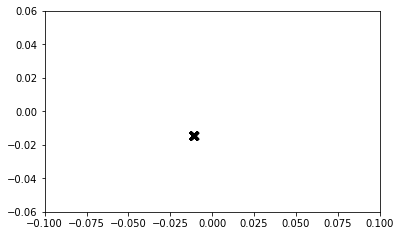

In [21]:
fig = MPP.figure()
ax = fig.add_subplot(1,1,1, aspect = 'equal')

ax.scatter(calculated_values.loc[calculated_values.index <= 3, 'p_{y}'].values \
           , calculated_values.loc[calculated_values.index <= 3, 'p_{x}'].values \
           , s = 50, marker = 'x', color = 'k', alpha = 0.4 \
          )
ax.set_ylim([-0.06,0.06])
ax.set_xlim([-0.1,0.1])


The contact point matches, it was simply a weight put on the force plate, close to the center.

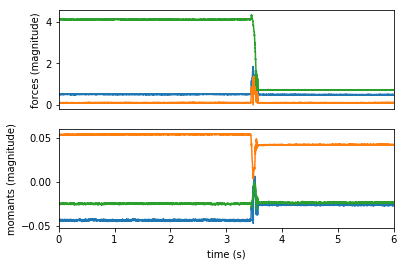

In [22]:
fig = MPP.figure()
ax = fig.add_subplot(2,1,1)
ax.plot(calculated_values.index, calculated_values.loc[:, ['F_{x}', 'F_{y}', 'F_{z}']].values)
ax.set_ylabel('forces (magnitude)')
ax.get_xaxis().set_visible(False)

ax = fig.add_subplot(2,1,2, sharex = ax) #, sharey = ax
ax.plot(calculated_values.index, calculated_values.loc[:, ['M_{x}', 'M_{y}', 'M_{z}']].values)
ax.set_ylabel('momants (magnitude)')
ax.set_xlabel('time (s)')
ax.set_xlim([calculated_values.index[0], calculated_values.index[-1]])
MPP.show();

This is also plausible with the measured scenario.

# Summary


I hope you found this calculation useful: it is a nice little demonstration of the versatility of `sympy`, and it forwards us towards meaningful measurements from raw voltages. 

# Next:
[ForcePlates III: Probabilistic Calibration of Magnitude](../fpcalibration1)

We'll have to correct the units, which are still "Volts" so far.

___

# BONUS: Inversion by Table Analogy 

**This I provide with reduced comment density**, thus only for interested readers.
It will help you to model and predict Kistler channel outputs, given a certan (theoretical) impact force vector and impact position.


What will help to analytically solve this physically indeterminate system is an analogy to a table-like board, hung up on linear springs in different directions. 
By taking the stiffness of the springs towards infinity, one can solve the horizontal and vertical components..


inversion: calculation of force components from given force + impact point


In [23]:
invert_equations = [SYM.Eq(param, eqn).simplify() for param, eqn in all_solutions.items() ]
solutes = force_components

print(len(invert_equations), len(solutes))
inverse_solution = [sol for sol in SYM.nonlinsolve(invert_equations, solutes)][0]
inverse_solution = {solutes[nr]: invs for nr, invs in enumerate(inverse_solution)}
PrintSolution(inverse_solution)

9 8

 ____________________
fx_{01}
____________________
0.5⋅F_{x} + 0.233333333333333⋅F_{y} - 6.66666666666667⋅M_{z} - 0.4666666666666
67⋅fy_{12}

 ____________________
fx_{23}
____________________
0.5⋅F_{x} - 0.233333333333333⋅F_{y} + 6.66666666666667⋅M_{z} + 0.4666666666666
67⋅fy_{12}

 ____________________
fy_{03}
____________________
F_{y} - fy_{12}

 ____________________
fy_{12}
____________________
fy_{12}

 ____________________
fz_{0}
____________________
F_{z}                                  
───── - 14.2857142857143⋅M_{y} - fz_{3}
  2                                    

 ____________________
fz_{1}
____________________
6.66666666666667⋅M_{x} + 14.2857142857143⋅M_{y} + fz_{3}

 ____________________
fz_{2}
____________________
F_{z}                                  
───── - 6.66666666666667⋅M_{x} - fz_{3}
  2                                    

 ____________________
fz_{3}
____________________
fz_{3}



The table analogy is **statically indeterminate**. But we can help it with linear springs.

https://physics.stackexchange.com/questions/257546/balancing-orthogonal-forces-on-2d-plane-with-arbitrary-placement

https://physics.stackexchange.com/questions/276007/estimate-the-reaction-force-on-each-leg-of-a-4-legged-table

We will below use a rotated, shifted "ghost" reference frame, for which some definitions are required.

clockwise rotation around the z axes:
$$ R_z = \begin{bmatrix}\cos \theta &-\sin \theta &0\\[3pt]\sin \theta &\cos \theta &0\\[3pt]0&0&1\\\end{bmatrix}$$


small angle approximation:
\begin{aligned}\sin \theta &\approx \theta \\\cos \theta &\approx 1-{\frac {\theta ^{2}}{2}}\approx 1\\\tan \theta &\approx \theta \end{aligned}

In [24]:
# angles for fake rotation in linear spring approximation
theta = SYM.symbols('theta_{x:z}')

# use small angle approximation: tan(theta) = theta
saa_subs = []
for ang in theta:
    saa_subs = saa_subs + SmallAngleApprox(ang) 

# artificial spring constant = (very low) elasticity of the legs
k = SYM.symbols('k')


## Linear Spring Table I: $z$-Direction

solving for $fz_3$

In [25]:


### infinitesimal deflection with a ghost reference frame
# translation: offsets in all directions
dj = SYM.symbols('d_{x:z}')

# rotation: tilt angles in all directions
# theta defined above

# ghost reference frame
ghost = forceplate.orientnew('ghost', 'Body', theta[::-1], 'ZYX')
ghost_coordinates = [ghost.x, ghost.y, ghost.z]

ghost_impact = impact.locatenew('gP', MakeVector(dj, coordinates))

# leg points
ghost_sq = [ChangeAFrame(sq[i], forceplate, ghost) for i in leg_ids]
ghost_legs = [ghost_impact.locatenew('gQ_{%i}' % (i), ghost_sq[i]) for i in leg_ids]


di = [ghost_legs[i].pos_from(legs[i]).express(ghost).subs(saa_subs) for i in leg_ids]
for dist in di:
    SYM.pprint(dist)

(d_{x} - θ_{y}⋅(d_{z} + p_{z}) + θ_{z}⋅(d_{y} + p_{y} - q_{y})) ghost_x + (-p_
{y} + q_{y} + θ_{x}⋅(d_{z} + p_{z}) + (θ_{x}⋅θ_{y} - θ_{z})⋅(d_{x} + p_{x} - q
_{x}) + (θ_{x}⋅θ_{y}⋅θ_{z} + 1)⋅(d_{y} + p_{y} - q_{y})) ghost_y + (d_{z} + (-
θ_{x} + θ_{y}⋅θ_{z})⋅(d_{y} + p_{y} - q_{y}) + (θ_{x}⋅θ_{z} + θ_{y})⋅(d_{x} +
p_{x} - q_{x})) ghost_z
(d_{x} - θ_{y}⋅(d_{z} + p_{z}) + θ_{z}⋅(d_{y} + p_{y} - q_{y})) ghost_x + (-p_
{y} + q_{y} + θ_{x}⋅(d_{z} + p_{z}) + (θ_{x}⋅θ_{y} - θ_{z})⋅(d_{x} + p_{x} + q
_{x}) + (θ_{x}⋅θ_{y}⋅θ_{z} + 1)⋅(d_{y} + p_{y} - q_{y})) ghost_y + (d_{z} + (-
θ_{x} + θ_{y}⋅θ_{z})⋅(d_{y} + p_{y} - q_{y}) + (θ_{x}⋅θ_{z} + θ_{y})⋅(d_{x} +
p_{x} + q_{x})) ghost_z
(d_{x} - θ_{y}⋅(d_{z} + p_{z}) + θ_{z}⋅(d_{y} + p_{y} + q_{y})) ghost_x + (-p_
{y} - q_{y} + θ_{x}⋅(d_{z} + p_{z}) + (θ_{x}⋅θ_{y} - θ_{z})⋅(d_{x} + p_{x} + q
_{x}) + (θ_{x}⋅θ_{y}⋅θ_{z} + 1)⋅(d_{y} + p_{y} + q_{y})) ghost_y + (d_{z} + (-
θ_{x} + θ_{y}⋅θ_{z})⋅(d_{y} + p_{y} + q_{y}) + (θ_{x}⋅θ_{z} + θ_{y})⋅(d_{x} +
p_{x} +

In [26]:
fz_subs = [(theta[2], 0), (dj[0], 0), (dj[1], 0)]

fz_i = [k*(-di[i].dot(ghost.z).subs(fz_subs).factor(qj)) for i in leg_ids] # 
fz_i

[k⋅(-d_{z} - p_{x}⋅θ_{y} + p_{y}⋅θ_{x} + q_{x}⋅θ_{y} - q_{y}⋅θ_{x}), k⋅(-d_{z}
 - p_{x}⋅θ_{y} + p_{y}⋅θ_{x} - q_{x}⋅θ_{y} - q_{y}⋅θ_{x}), k⋅(-d_{z} - p_{x}⋅θ
_{y} + p_{y}⋅θ_{x} - q_{x}⋅θ_{y} + q_{y}⋅θ_{x}), k⋅(-d_{z} - p_{x}⋅θ_{y} + p_{
y}⋅θ_{x} + q_{x}⋅θ_{y} + q_{y}⋅θ_{x})]

In [27]:

forcebalance_z = SYM.Eq(Fj[2], sum(fz_i))
dz_solution = [sol for sol in SYM.solveset(forcebalance_z, dj[2])][0]
SYM.pprint(dz_solution)



-(F_{z} + 4⋅k⋅p_{x}⋅θ_{y} - 4⋅k⋅p_{y}⋅θ_{x}) 
─────────────────────────────────────────────
                     4⋅k                     


In [28]:
Mz_i = [sq[i].cross(fz_i[i]*z) for i in leg_ids]
print(Mz_i)

[k*(-p_{y} + q_{y})*(-d_{z} - p_{x}*theta_{y} + p_{y}*theta_{x} + q_{x}*theta_{y} - q_{y}*theta_{x})*fp.x - k*(-p_{x} + q_{x})*(-d_{z} - p_{x}*theta_{y} + p_{y}*theta_{x} + q_{x}*theta_{y} - q_{y}*theta_{x})*fp.y, k*(-p_{y} + q_{y})*(-d_{z} - p_{x}*theta_{y} + p_{y}*theta_{x} - q_{x}*theta_{y} - q_{y}*theta_{x})*fp.x - k*(-p_{x} - q_{x})*(-d_{z} - p_{x}*theta_{y} + p_{y}*theta_{x} - q_{x}*theta_{y} - q_{y}*theta_{x})*fp.y, k*(-p_{y} - q_{y})*(-d_{z} - p_{x}*theta_{y} + p_{y}*theta_{x} - q_{x}*theta_{y} + q_{y}*theta_{x})*fp.x - k*(-p_{x} - q_{x})*(-d_{z} - p_{x}*theta_{y} + p_{y}*theta_{x} - q_{x}*theta_{y} + q_{y}*theta_{x})*fp.y, k*(-p_{y} - q_{y})*(-d_{z} - p_{x}*theta_{y} + p_{y}*theta_{x} + q_{x}*theta_{y} + q_{y}*theta_{x})*fp.x - k*(-p_{x} + q_{x})*(-d_{z} - p_{x}*theta_{y} + p_{y}*theta_{x} + q_{x}*theta_{y} + q_{y}*theta_{x})*fp.y]


In [29]:
Mx = sum([m.dot(x) for m in Mz_i])
My = sum([m.dot(y) for m in Mz_i])
print(Mx, '\n', My)

k*(-p_{y} - q_{y})*(-d_{z} - p_{x}*theta_{y} + p_{y}*theta_{x} - q_{x}*theta_{y} + q_{y}*theta_{x}) + k*(-p_{y} - q_{y})*(-d_{z} - p_{x}*theta_{y} + p_{y}*theta_{x} + q_{x}*theta_{y} + q_{y}*theta_{x}) + k*(-p_{y} + q_{y})*(-d_{z} - p_{x}*theta_{y} + p_{y}*theta_{x} - q_{x}*theta_{y} - q_{y}*theta_{x}) + k*(-p_{y} + q_{y})*(-d_{z} - p_{x}*theta_{y} + p_{y}*theta_{x} + q_{x}*theta_{y} - q_{y}*theta_{x}) 
 -k*(-p_{x} - q_{x})*(-d_{z} - p_{x}*theta_{y} + p_{y}*theta_{x} - q_{x}*theta_{y} - q_{y}*theta_{x}) - k*(-p_{x} - q_{x})*(-d_{z} - p_{x}*theta_{y} + p_{y}*theta_{x} - q_{x}*theta_{y} + q_{y}*theta_{x}) - k*(-p_{x} + q_{x})*(-d_{z} - p_{x}*theta_{y} + p_{y}*theta_{x} + q_{x}*theta_{y} - q_{y}*theta_{x}) - k*(-p_{x} + q_{x})*(-d_{z} - p_{x}*theta_{y} + p_{y}*theta_{x} + q_{x}*theta_{y} + q_{y}*theta_{x})


In [30]:
# solve for theta
momentbalance = [SYM.Eq(Mj[0], Mx), SYM.Eq(Mj[1], My)]
print(momentbalance)
angle_solutions = [sol for sol in SYM.nonlinsolve(momentbalance, theta[:2])][0]
angle_solutions

[Eq(M_{x}, k*(-p_{y} - q_{y})*(-d_{z} - p_{x}*theta_{y} + p_{y}*theta_{x} - q_{x}*theta_{y} + q_{y}*theta_{x}) + k*(-p_{y} - q_{y})*(-d_{z} - p_{x}*theta_{y} + p_{y}*theta_{x} + q_{x}*theta_{y} + q_{y}*theta_{x}) + k*(-p_{y} + q_{y})*(-d_{z} - p_{x}*theta_{y} + p_{y}*theta_{x} - q_{x}*theta_{y} - q_{y}*theta_{x}) + k*(-p_{y} + q_{y})*(-d_{z} - p_{x}*theta_{y} + p_{y}*theta_{x} + q_{x}*theta_{y} - q_{y}*theta_{x})), Eq(M_{y}, -k*(-p_{x} - q_{x})*(-d_{z} - p_{x}*theta_{y} + p_{y}*theta_{x} - q_{x}*theta_{y} - q_{y}*theta_{x}) - k*(-p_{x} - q_{x})*(-d_{z} - p_{x}*theta_{y} + p_{y}*theta_{x} - q_{x}*theta_{y} + q_{y}*theta_{x}) - k*(-p_{x} + q_{x})*(-d_{z} - p_{x}*theta_{y} + p_{y}*theta_{x} + q_{x}*theta_{y} - q_{y}*theta_{x}) - k*(-p_{x} + q_{x})*(-d_{z} - p_{x}*theta_{y} + p_{y}*theta_{x} + q_{x}*theta_{y} + q_{y}*theta_{x}))]


⎛             2              2                                            2   
⎜- M_{x}⋅p_{x}  - M_{x}⋅q_{x}  - M_{y}⋅p_{x}⋅p_{y} + 4⋅d_{z}⋅k⋅p_{y}⋅q_{x}   -
⎜──────────────────────────────────────────────────────────────────────────, ─
⎜               ⎛     2      2        2      2        2      2⎞               
⎝           4⋅k⋅⎝p_{x} ⋅q_{y}  + p_{y} ⋅q_{x}  + q_{x} ⋅q_{y} ⎠               

⎛                               2              2                        2⎞ ⎞
⎝M_{x}⋅p_{x}⋅p_{y} + M_{y}⋅p_{y}  + M_{y}⋅q_{y}  + 4⋅d_{z}⋅k⋅p_{x}⋅q_{y} ⎠ ⎟
───────────────────────────────────────────────────────────────────────────⎟
               ⎛     2      2        2      2        2      2⎞             ⎟
           4⋅k⋅⎝p_{x} ⋅q_{y}  + p_{y} ⋅q_{x}  + q_{x} ⋅q_{y} ⎠             ⎠

In [31]:

theta_subs = list(zip(theta, angle_solutions))
dz_eqn = SYM.Eq(dj[2], dz_solution.subs(theta_subs))
dz_subs = [(dj[2], [sol for sol in SYM.solveset(dz_eqn, dj[2])][0])]

In [32]:
re_theta_subs = list(zip(theta, [ts.subs(dz_subs) for ts in angle_solutions]))

force_solutions = [fz_i[i].subs(dz_subs+re_theta_subs) for i in leg_ids]
print(force_solutions)

[k*(p_{x}*(M_{x}*p_{x}*p_{y} + M_{y}*p_{y}**2 + M_{y}*q_{y}**2 - p_{x}*(F_{z}*p_{x}**2*q_{y}**2 + F_{z}*p_{y}**2*q_{x}**2 + F_{z}*q_{x}**2*q_{y}**2 + M_{x}*p_{y}*q_{x}**2 - M_{y}*p_{x}*q_{y}**2)/q_{x}**2)/(4*k*(p_{x}**2*q_{y}**2 + p_{y}**2*q_{x}**2 + q_{x}**2*q_{y}**2)) + p_{y}*(-M_{x}*p_{x}**2 - M_{x}*q_{x}**2 - M_{y}*p_{x}*p_{y} - p_{y}*(F_{z}*p_{x}**2*q_{y}**2 + F_{z}*p_{y}**2*q_{x}**2 + F_{z}*q_{x}**2*q_{y}**2 + M_{x}*p_{y}*q_{x}**2 - M_{y}*p_{x}*q_{y}**2)/q_{y}**2)/(4*k*(p_{x}**2*q_{y}**2 + p_{y}**2*q_{x}**2 + q_{x}**2*q_{y}**2)) - q_{x}*(M_{x}*p_{x}*p_{y} + M_{y}*p_{y}**2 + M_{y}*q_{y}**2 - p_{x}*(F_{z}*p_{x}**2*q_{y}**2 + F_{z}*p_{y}**2*q_{x}**2 + F_{z}*q_{x}**2*q_{y}**2 + M_{x}*p_{y}*q_{x}**2 - M_{y}*p_{x}*q_{y}**2)/q_{x}**2)/(4*k*(p_{x}**2*q_{y}**2 + p_{y}**2*q_{x}**2 + q_{x}**2*q_{y}**2)) - q_{y}*(-M_{x}*p_{x}**2 - M_{x}*q_{x}**2 - M_{y}*p_{x}*p_{y} - p_{y}*(F_{z}*p_{x}**2*q_{y}**2 + F_{z}*p_{y}**2*q_{x}**2 + F_{z}*q_{x}**2*q_{y}**2 + M_{x}*p_{y}*q_{x}**2 - M_{y}*p_{x}*q_{y}*

Lovely!

In [33]:
force_elements = [fc.simplify() for fc in force_solutions]
SYM.pprint(force_elements[3])

fz3_subs = [(fz[3], force_elements[3])]

F_{z}⋅p_{x}⋅q_{y} - F_{z}⋅p_{y}⋅q_{x} + F_{z}⋅q_{x}⋅q_{y} - M_{x}⋅q_{x} - M_{y
──────────────────────────────────────────────────────────────────────────────
                                    4⋅q_{x}⋅q_{y}                             

}⋅q_{y}
───────
       


In [34]:
inverse_solution = {param: eqn.subs(fz3_subs).subs(fp_dimensions) for param, eqn in inverse_solution.items()}
PrintSolution(inverse_solution)


 ____________________
fx_{01}
____________________
0.5⋅F_{x} + 0.233333333333333⋅F_{y} - 6.66666666666667⋅M_{z} - 0.4666666666666
67⋅fy_{12}

 ____________________
fx_{23}
____________________
0.5⋅F_{x} - 0.233333333333333⋅F_{y} + 6.66666666666667⋅M_{z} + 0.4666666666666
67⋅fy_{12}

 ____________________
fy_{03}
____________________
F_{y} - fy_{12}

 ____________________
fy_{12}
____________________
fy_{12}

 ____________________
fz_{0}
____________________
-7.14285714285714⋅F_{z}⋅p_{x} + 3.33333333333333⋅F_{z}⋅p_{y} + 0.25⋅F_{z} + 3.
33333333333333⋅M_{x} - 7.14285714285714⋅M_{y}

 ____________________
fz_{1}
____________________
7.14285714285714⋅F_{z}⋅p_{x} - 3.33333333333333⋅F_{z}⋅p_{y} + 0.25⋅F_{z} + 3.3
3333333333333⋅M_{x} + 7.14285714285714⋅M_{y}

 ____________________
fz_{2}
____________________
-7.14285714285714⋅F_{z}⋅p_{x} + 3.33333333333333⋅F_{z}⋅p_{y} + 0.25⋅F_{z} - 3.
33333333333333⋅M_{x} + 7.14285714285714⋅M_{y}

 ____________________
fz_{3}
____________________
7.14285714

## Linear Spring Table II: $y$-Direction

solving for $fy_{12} = g_{1y}+g_{2y}$ (forces in $y$-direction on legs 2 and 3)



In [35]:

fy_subs = [(theta[0], 0), (theta[1], 0), (dj[2], 0)]

fy_i = [k*-(di[i].subs(fy_subs)) for i in leg_ids] # 
fy_i = [ChangeAFrame(fy, ghost, forceplate).dot(y) for fy in fy_i]
print(fy_i)

[k*(-d_{y} + theta_{z}*(d_{x} + p_{x} - q_{x})), k*(-d_{y} + theta_{z}*(d_{x} + p_{x} + q_{x})), k*(-d_{y} + theta_{z}*(d_{x} + p_{x} + q_{x})), k*(-d_{y} + theta_{z}*(d_{x} + p_{x} - q_{x}))]


In [36]:
y_forcebalance = SYM.Eq(Fj[1], sum(fy_i) )
dy_solution = [sol.simplify() for sol in SYM.solveset(y_forcebalance, dj[1])][0]
SYM.pprint(dy_solution)

  F_{y}                            
- ───── + d_{x}⋅θ_{z} + p_{x}⋅θ_{z}
   4⋅k                             


In [37]:
Mi = [sq[i].cross(fy_i[i]*y)+rq[i].cross(fy_i[i]*y) for i in leg_ids]
print(Mi)

[k*p_{z}*(-d_{y} + theta_{z}*(d_{x} + p_{x} - q_{x}))*fp.x + (k*q_{x}*(-d_{y} + theta_{z}*(d_{x} + p_{x} - q_{x})) + k*(-d_{y} + theta_{z}*(d_{x} + p_{x} - q_{x}))*(-p_{x} + q_{x}))*fp.z, k*p_{z}*(-d_{y} + theta_{z}*(d_{x} + p_{x} + q_{x}))*fp.x + (-k*q_{x}*(-d_{y} + theta_{z}*(d_{x} + p_{x} + q_{x})) + k*(-d_{y} + theta_{z}*(d_{x} + p_{x} + q_{x}))*(-p_{x} - q_{x}))*fp.z, k*p_{z}*(-d_{y} + theta_{z}*(d_{x} + p_{x} + q_{x}))*fp.x + (-k*q_{x}*(-d_{y} + theta_{z}*(d_{x} + p_{x} + q_{x})) + k*(-d_{y} + theta_{z}*(d_{x} + p_{x} + q_{x}))*(-p_{x} - q_{x}))*fp.z, k*p_{z}*(-d_{y} + theta_{z}*(d_{x} + p_{x} - q_{x}))*fp.x + (k*q_{x}*(-d_{y} + theta_{z}*(d_{x} + p_{x} - q_{x})) + k*(-d_{y} + theta_{z}*(d_{x} + p_{x} - q_{x}))*(-p_{x} + q_{x}))*fp.z]


In [38]:
Mz = sum([m.dot(z) for m in Mi])


In [39]:
# solve for theta
momentbalance = [SYM.Eq(Mj[2]+Tz, Mz)]
angle_solution = [sol for sol in SYM.nonlinsolve(momentbalance, [theta[2]])][0][0].factor(k).simplify()
angle_solution

   -M_{z} - T_{z} + 4⋅d_{y}⋅k⋅p_{x}  
─────────────────────────────────────
    ⎛                   2          2⎞
4⋅k⋅⎝d_{x}⋅p_{x} + p_{x}  + 2⋅q_{x} ⎠

In [40]:
theta_subs = [(theta[2], angle_solution)]
dy_eqn = SYM.Eq(dj[1], dy_solution.subs(theta_subs))
dy_subs = [(dj[1], [sol for sol in SYM.solveset(dy_eqn, dj[1])][0])]
dy_subs

⎡⎛        ⎛                               2                2                  
⎢⎜       -⎝F_{y}⋅d_{x}⋅p_{x} + F_{y}⋅p_{x}  + 2⋅F_{y}⋅q_{x}  + M_{z}⋅d_{x} + M
⎢⎜d_{y}, ─────────────────────────────────────────────────────────────────────
⎢⎜                                                                  2         
⎣⎝                                                         8⋅k⋅q_{x}          

                                      ⎞ ⎞⎤
_{z}⋅p_{x} + T_{z}⋅d_{x} + T_{z}⋅p_{x}⎠ ⎟⎥
────────────────────────────────────────⎟⎥
                                        ⎟⎥
                                        ⎠⎦

In [41]:
re_theta_subs = [(theta[2], angle_solution.subs(dy_subs))]

force_solutions = [fy_i[i].subs(dy_subs+re_theta_subs) for i in leg_ids]
print(force_solutions)

[k*((-M_{z} - T_{z} - p_{x}*(F_{y}*d_{x}*p_{x} + F_{y}*p_{x}**2 + 2*F_{y}*q_{x}**2 + M_{z}*d_{x} + M_{z}*p_{x} + T_{z}*d_{x} + T_{z}*p_{x})/(2*q_{x}**2))*(d_{x} + p_{x} - q_{x})/(4*k*(d_{x}*p_{x} + p_{x}**2 + 2*q_{x}**2)) + (F_{y}*d_{x}*p_{x} + F_{y}*p_{x}**2 + 2*F_{y}*q_{x}**2 + M_{z}*d_{x} + M_{z}*p_{x} + T_{z}*d_{x} + T_{z}*p_{x})/(8*k*q_{x}**2)), k*((-M_{z} - T_{z} - p_{x}*(F_{y}*d_{x}*p_{x} + F_{y}*p_{x}**2 + 2*F_{y}*q_{x}**2 + M_{z}*d_{x} + M_{z}*p_{x} + T_{z}*d_{x} + T_{z}*p_{x})/(2*q_{x}**2))*(d_{x} + p_{x} + q_{x})/(4*k*(d_{x}*p_{x} + p_{x}**2 + 2*q_{x}**2)) + (F_{y}*d_{x}*p_{x} + F_{y}*p_{x}**2 + 2*F_{y}*q_{x}**2 + M_{z}*d_{x} + M_{z}*p_{x} + T_{z}*d_{x} + T_{z}*p_{x})/(8*k*q_{x}**2)), k*((-M_{z} - T_{z} - p_{x}*(F_{y}*d_{x}*p_{x} + F_{y}*p_{x}**2 + 2*F_{y}*q_{x}**2 + M_{z}*d_{x} + M_{z}*p_{x} + T_{z}*d_{x} + T_{z}*p_{x})/(2*q_{x}**2))*(d_{x} + p_{x} + q_{x})/(4*k*(d_{x}*p_{x} + p_{x}**2 + 2*q_{x}**2)) + (F_{y}*d_{x}*p_{x} + F_{y}*p_{x}**2 + 2*F_{y}*q_{x}**2 + M_{z}*d_{x} + M

In [42]:
force_elements = [fc.simplify() for fc in force_solutions]
SYM.pprint(force_elements)

fy12_subs = [(fy12, force_elements[1]+force_elements[2])]
fy12_subs

⎡F_{y}⋅p_{x} + 2⋅F_{y}⋅q_{x} + M_{z} + T_{z}  -(F_{y}⋅p_{x} - 2⋅F_{y}⋅q_{x} + 
⎢───────────────────────────────────────────, ────────────────────────────────
⎣                  8⋅q_{x}                                        8⋅q_{x}     

M_{z} + T_{z})   -(F_{y}⋅p_{x} - 2⋅F_{y}⋅q_{x} + M_{z} + T_{z})   F_{y}⋅p_{x} 
───────────────, ───────────────────────────────────────────────, ────────────
                                     8⋅q_{x}                                  

+ 2⋅F_{y}⋅q_{x} + M_{z} + T_{z}⎤
───────────────────────────────⎥
      8⋅q_{x}                  ⎦


⎡⎛         -(F_{y}⋅p_{x} - 2⋅F_{y}⋅q_{x} + M_{z} + T_{z}) ⎞⎤
⎢⎜fy_{12}, ───────────────────────────────────────────────⎟⎥
⎣⎝                             4⋅q_{x}                    ⎠⎦

consistent with weight balance

http://www.algarcia.org/AnimationPhysics/BalanceTutorial.pdf

## Application to Data

In [43]:
inverse_solutions = {param: eqn.subs(fy12_subs).subs(fz3_subs).simplify() \
                      for param, eqn in inverse_solution.items() \
                    } 


PrintSolution(inverse_solutions)


 ____________________
fx_{01}
____________________
0.5⋅F_{x} + 3.33333333333333⋅F_{y}⋅p_{x} - 3.33333333333333⋅M_{z} + 3.33333333
333333⋅T_{z}

 ____________________
fx_{23}
____________________
0.5⋅F_{x} - 3.33333333333333⋅F_{y}⋅p_{x} + 3.33333333333333⋅M_{z} - 3.33333333
333333⋅T_{z}

 ____________________
fy_{03}
____________________
7.14285714285714⋅F_{y}⋅p_{x} + 0.5⋅F_{y} + 7.14285714285714⋅M_{z} + 7.14285714
285714⋅T_{z}

 ____________________
fy_{12}
____________________
-7.14285714285714⋅F_{y}⋅p_{x} + 0.5⋅F_{y} - 7.14285714285714⋅M_{z} - 7.1428571
4285714⋅T_{z}

 ____________________
fz_{0}
____________________
-7.14285714285714⋅F_{z}⋅p_{x} + 3.33333333333333⋅F_{z}⋅p_{y} + 0.25⋅F_{z} + 3.
33333333333333⋅M_{x} - 7.14285714285714⋅M_{y}

 ____________________
fz_{1}
____________________
7.14285714285714⋅F_{z}⋅p_{x} - 3.33333333333333⋅F_{z}⋅p_{y} + 0.25⋅F_{z} + 3.3
3333333333333⋅M_{x} + 7.14285714285714⋅M_{y}

 ____________________
fz_{2}
____________________
-7.14285714285714⋅F_{

In [44]:
# generate conversion functions
ParametersToComponents = { str(param): \
                              SYM.lambdify(parameters, eqn.subs(fp_dimensions), "numpy") \
                          for param, eqn in inverse_solutions.items()\
                         }
parameters

[F_{x}, F_{y}, F_{z}, M_{x}, M_{y}, M_{z}, T_{z}, p_{x}, p_{y}]

In [45]:
paramvectors = [calculated_values.loc[:,col].values for col in calculated_values.columns]

calculated_params = PD.DataFrame.from_dict({param: eqn(*paramvectors) for param, eqn in ParametersToComponents.items()})
calculated_params.head()

fx_{01}  fx_{23}  fy_{03}  fy_{12}   fz_{0}   fz_{1}   fz_{2}   fz_{3}
0  0.23029  0.26663 -0.34818  0.43043  0.77028  0.98722  1.82868  0.51599
1  0.23419  0.27086 -0.36121  0.44408  0.77703  0.99204  1.83637  0.51862
2  0.22670  0.26210 -0.35700  0.44018  0.77519  0.99169  1.82953  0.52077
3  0.22789  0.26372 -0.35472  0.44290  0.77445  0.99274  1.83379  0.52057
4  0.23003  0.26658 -0.35802  0.44402  0.77034  0.98997  1.83031  0.52186

In [46]:
reference_values = data.loc[:, ['Fx12', 'Fx34', 'Fy14', 'Fy23', 'Fz1', 'Fz2', 'Fz3', 'Fz4']]
reference_values.head()

Fx12     Fx34     Fy14     Fy23      Fz1      Fz2      Fz3      Fz4
time                                                                         
0.000  0.38455  0.11237 -0.01762  0.09987  0.99141  0.76610  2.04981  0.29487
0.001  0.39424  0.11081 -0.01825  0.10112  0.99391  0.77516  2.05325  0.30174
0.002  0.38580  0.10300 -0.01606  0.09925  0.99703  0.76985  2.05137  0.29893
0.003  0.38549  0.10612 -0.01700  0.10518  0.99516  0.77204  2.05450  0.29986
0.004  0.38830  0.10831 -0.01887  0.10487  0.99109  0.76922  2.05106  0.30111

In [47]:
print (calculated_params - reference_values.values)

      fx_{01}  fx_{23}  fy_{03}  fy_{12}   fz_{0}   fz_{1}   fz_{2}   fz_{3}
0    -0.15426  0.15426 -0.33056  0.33056 -0.22112  0.22112 -0.22112  0.22112
1    -0.16005  0.16005 -0.34296  0.34296 -0.21688  0.21688 -0.21688  0.21688
2    -0.15910  0.15910 -0.34093  0.34093 -0.22184  0.22184 -0.22184  0.22184
3    -0.15760  0.15760 -0.33772  0.33772 -0.22071  0.22071 -0.22071  0.22071
4    -0.15827  0.15827 -0.33915  0.33915 -0.22075  0.22075 -0.22075  0.22075
5    -0.15713  0.15713 -0.33671  0.33671 -0.21922  0.21922 -0.21922  0.21922
6    -0.15905  0.15905 -0.34082  0.34082 -0.22165  0.22165 -0.22165  0.22165
7    -0.15969  0.15969 -0.34219  0.34219 -0.21768  0.21768 -0.21768  0.21768
8    -0.15634  0.15634 -0.33501  0.33501 -0.21823  0.21823 -0.21823  0.21823
9    -0.15830  0.15830 -0.33922  0.33922 -0.21823  0.21823 -0.21823  0.21823
10   -0.15647  0.15647 -0.33530  0.33530 -0.22073  0.22073 -0.22073  0.22073
11   -0.15978  0.15978 -0.34239  0.34239 -0.22169  0.22169 -0.22169  0.22169

Note the symmetry in the deviation from original measurements. Though we solved the problem, this is only one of an infinite number of solutions.